# Multipoint observations of solar coronal mass ejections from April 2020 - April 2024

Notebook for creating the HELIO4CAST LineupCAT v2.0

Authors: E. Weiler, C. Möstl, E. E. Davies, Austrian Space Weather Office, GeoSphere Austria

**last update to code: 2024 May 8**

**last update to catalog: 2024 May 6**


To run this code, a conda environment is needed, dependencies are listed under environment.yml, and pip in requirements.txt.


**Data sources**

The ICME catalog ICMECATv2.2. The latest versions can be downloaded from https://doi.org/10.6084/m9.figshare.6356420 or https://helioforecast.space/icmecat

The HELCATS HIGeoCat and the DONKI database are downloaded automatically when running this script.

In situ data is not necessary for this notebook, but the data behind the ICMECAT can be downloaded into a directory (defined in config.py) from this figshare repository: https://doi.org/10.6084/m9.figshare.11973693


---

**MIT LICENSE**

Copyright 2024, Eva Weiler

Permission is hereby granted, free of charge, to any person obtaining a copy of this 
software and associated documentation files (the "Software"), to deal in the Software
without restriction, including without limitation the rights to use, copy, modify, 
merge, publish, distribute, sublicense, and/or sell copies of the Software, and to 
permit persons to whom the Software is furnished to do so, subject to the following 
conditions:

The above copyright notice and this permission notice shall be included in all copies 
or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, 
INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A
PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT 
HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF 
CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE 
OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.





In [1]:
last_update='2025-April-22'

In [2]:
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc
import seaborn as sns
import numpy as np
import scipy.io

from scipy import stats
import matplotlib as mpl
import sys
from datetime import timedelta
import datetime
import time
import pickle
import os
import copy
import urllib
import json
import warnings
import importlib
import pandas as pd

#import heliocats.data as hd

import sunpy
import sunpy.time
from sunpy.time import parse_time

import heliopy.spice as spice
import heliopy.data.spice as spicedata
from sunpy.coordinates import frames, get_horizons_coord

import astropy
import astropy.constants as const
from astropy.io.votable import parse_single_table

########### make directories first time
resdir='plots'
if os.path.isdir(resdir) == False: os.mkdir(resdir)

datadir='data'
if os.path.isdir(datadir) == False: os.mkdir(datadir)

lineupsdir='lineups'
if os.path.isdir(lineupsdir) == False: os.mkdir(lineupsdir)

plt.rcParams["figure.figsize"] = (15,8)
plt.close('all')

#constants: 
#solar radius
Rs_in_AU=float(const.R_sun/const.au)
#define AU in km
AU_in_km=const.au.value/1e3

print('done')

done


# 1) Load catalogs

### 1a) ICMECAT

In [22]:
########### load ICMECAT v2.2
#file='icmecat/HELIO4CAST_ICMECAT_v22_pandas.p'
#file='icmecat_draft_april_2_2025/HELIO4CAST_ICMECAT_v23_pandas.p'

import pandas as pd
url='https://helioforecast.space/static/sync/icmecat/HELIO4CAST_ICMECAT_v23.csv'
ic=pd.read_csv(url)
ic.keys()

print()
print('loaded ', file)
print()
print('Keys (parameters) in this pandas data frame are:')

#[ic,h,p]=pickle.load(open(file, "rb" ) ) 


loaded  icmecat_draft_april_2_2025/HELIO4CAST_ICMECAT_v23_pandas.p

Keys (parameters) in this pandas data frame are:


In [23]:
ic

,Unnamed: 0,icmecat_id,sc_insitu,icme_start_time,mo_start_time,mo_end_time,mo_sc_heliodistance,mo_sc_long_heeq,mo_sc_lat_heeq,icme_duration,...,mo_density_mean,mo_density_std,mo_temperature_mean,mo_temperature_std,sheath_speed_mean,sheath_speed_std,sheath_density_mean,sheath_density_std,sheath_pdyn_mean,sheath_pdyn_std
0,0,ICME_STEREO_A_MOESTL_20241220_01,STEREO-A,2024-12-20T11:32Z,2024-12-20T14:44Z,2024-12-20T22:34Z,0.9672,28.58,-4.96,11.03,...,3.0,1.4,0.0,0.0,363.6,7.7,8.9,2.7,2.0,0.6
1,1,ICME_STEREO_A_MOESTL_20241218_01,STEREO-A,2024-12-18T06:17Z,2024-12-18T22:32Z,2024-12-20T02:00Z,0.9672,28.54,-4.79,43.72,...,2.2,0.7,0.0,0.0,338.7,23.2,14.1,5.1,2.6,0.8
2,2,ICME_Wind_MOESTL_20241217_01,Wind,2024-12-17T04:28Z,2024-12-17T05:28Z,2024-12-17T14:16Z,0.9732,-0.10,-1.17,9.80,...,20.3,10.0,297500.0,323800.5,541.5,19.5,42.2,6.7,20.9,4.5
3,3,ICME_BEPI_MOESTL_20241216_01,BepiColombo,2024-12-16T04:02Z,2024-12-16T06:39Z,2024-12-16T15:39Z,0.3343,51.21,-1.93,11.62,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,ICME_Wind_MOESTL_20241207_01,Wind,2024-12-07T23:14Z,2024-12-07T23:14Z,2024-12-08T17:50Z,0.9746,-0.17,0.02,18.60,...,7.8,3.6,65012.1,33690.2,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1896,1896,ICME_ULY_RICHARDSON_19910305_01,ULYSSES,1991-03-05T00:00Z,1991-03-05T00:00Z,1991-03-08T20:00Z,2.2833,-41.33,-3.42,92.00,...,1.3,1.1,25501.7,11677.5,NaN,NaN,NaN,NaN,NaN,NaN
1897,1897,ICME_ULY_RICHARDSON_19910226_01,ULYSSES,1991-02-26T22:00Z,1991-02-26T22:00Z,1991-02-27T17:00Z,2.2166,-36.80,-3.26,19.00,...,0.9,0.4,65951.4,24933.2,NaN,NaN,NaN,NaN,NaN,NaN
1898,1898,ICME_ULY_RICHARDSON_19910116_01,ULYSSES,1991-01-16T16:00Z,1991-01-16T16:00Z,1991-01-18T11:00Z,1.7583,-9.09,-1.75,43.00,...,0.9,0.1,55306.4,21032.7,NaN,NaN,NaN,NaN,NaN,NaN
1899,1899,ICME_ULY_RICHARDSON_19901225_01,ULYSSES,1990-12-25T14:00Z,1990-12-25T14:00Z,1990-12-28T12:00Z,1.5160,2.18,-0.49,70.00,...,1.8,1.1,52144.3,36250.8,NaN,NaN,NaN,NaN,NaN,NaN


### 1b) HIGeoCAT

In [5]:
#https://www.helcats-fp7.eu/

print('Load HIGeoCAT CMEs')

#LOAD HELCATS HIGeoCAT
url_higeocat='https://www.helcats-fp7.eu/catalogues/data/HCME_WP3_V06.vot'

try: urllib.request.urlretrieve(url_higeocat,'data/HCME_WP3_V06.vot')
except urllib.error.URLError as e:
    print('higeocat not loaded')

#with function from heliocats.cats
#higeocat=hc.load_higeocat_vot('data/HCME_WP3_V06.vot')
table = parse_single_table('data/HCME_WP3_V06.vot')
higeocat = table.array
higeocat_time=parse_time(higeocat['Date']).datetime    
higeocat_t0=parse_time(higeocat['SSE Launch']).datetime   #backprojected launch time

sse_speed=higeocat['SSE Speed']
sse_lon=higeocat['SSE HEEQ Long']
sse_lat=higeocat['SSE HEEQ Lat']
higeocat_name=np.array(higeocat['SC'].astype(str))
higeocat_id=np.array(higeocat['ID'].astype(str))

print('done')

Load HIGeoCAT CMEs
done


### 1c) DONKI catalog

In [6]:
#load all CMEs from DONKI database starting 2020-01-01
print('load DONKI CMEs')

url_donki='https://kauai.ccmc.gsfc.nasa.gov/DONKI/WS/get/CME?startDate=2020-01-01'
try: urllib.request.urlretrieve(url_donki,'data/DONKI.json')
except urllib.error.URLError as e:
    print('DONKI not loaded')

donki = pd.read_json('data/DONKI.json')
    
print('done')

load DONKI CMEs
done


# (2) Create multipoint CME catalog

Event identification is done with this animation (filename: 'april2020_april2024.mp4'): https://doi.org/10.6084/m9.figshare.15134745

The code to produce this animation is part of the heliocats package: 
https://github.com/EvaWeiler/ELEvo

In [7]:
#define Events from ICMECAT, add HIGEOcat if connection to in situ is evident
#HI arrival within +/- 24 hours at 1 AU

#add identified events from  HIGEOCAT and/or DONKI

#get indices in ICMECAT, HIGEOCAT, and DONKI:
def get_cat_ind(event_list,event_type):
    event_ind=[]
    event_ind_donki = []
    for i in np.arange(len(event_list)):        
            
        #HIGeoCAT    
        if event_type[i]==0:
            #print('hicat')
            event_ind.append(np.where(higeocat_id==event_list[i])[0])
            
        #ICMECAT    
        if event_type[i]==1:            
            #print('icmecat')
            index = np.where(ic.icmecat_id==event_list[i])[0]
            event_ind.append(index)
            if index.size == 0:
                print(i)
            
        #LASCO
        if event_type[i]==2:
            event_ind.append(np.where(ldf.time==event_list[i])[0])
            
        #DONKI    
        if event_type[i]==3:
            event_ind.append(np.where(donki.activityID==event_list[i])[0])
            
    return event_ind


In [24]:
lineups = pd.read_csv('LineupCAT_20250422.csv', sep=';', header=0)

group = lineups.groupby(lineups.event)['event_number'].unique()

event_ind=get_cat_ind(lineups.ID, lineups.event)

data=[]
for i in np.arange(0,len(lineups.event),1):
    
    #HI
    if lineups.event[i]==0:
        hi_time=parse_time(higeocat['Date'][event_ind[i]]).datetime

        coord = get_horizons_coord('STEREO-A', hi_time)
        sc_heeq = coord.transform_to(frames.HeliographicStonyhurst) #HEEQ

        sta_r = sc_heeq.radius.value
        sta_lon = np.deg2rad(sc_heeq.lon.value)
        sta_lat = np.deg2rad(sc_heeq.lat.value)

        data.append([lineups.event_number_new[i], lineups.lineupcat_id[i], hi_time[0], 
                    'HIA',
                     np.round(sta_r[0],3),
                     np.round(np.rad2deg(sta_lon[0]),1),
                     np.round(np.rad2deg(sta_lat[0]),1),
                    sse_lon[event_ind[i][0]],
                    sse_speed[event_ind[i][0]],
                     '-',
                     '-',
                    higeocat_id[event_ind[i][0]],
                     ' '
                     #lineups.Source[i]
                    ] )
    
  
    #in situ 
    if lineups.event[i]==1:

        #to avoid NaN in the table
        speed=np.rint(ic.icme_speed_mean[event_ind[i][0]])
        #print(speed)
        if np.isnan(speed): speed='-'


        data.append([lineups.event_number_new[i], lineups.lineupcat_id[i], ic.icme_start_time[event_ind[i][0]], 
                    ic.sc_insitu[event_ind[i][0]],
                    np.round(ic.mo_sc_heliodistance[event_ind[i][0]],3),                     
                    np.round(ic.mo_sc_long_heeq[event_ind[i][0]],1),
                    np.round(ic.mo_sc_lat_heeq[event_ind[i][0]],1),
                    '-',    
                    speed, 
                    ic.mo_bmax[event_ind[i][0]],
                    ic.mo_bzmin[event_ind[i][0]],
                    ic.icmecat_id[event_ind[i][0]],
                    ' '
                    #lineups.Source[i]
                    ] )
    
    #DONKI
    if lineups.event[i]==3:
        donki_time=parse_time(donki.iloc[event_ind[i][0]].get('cmeAnalyses')[0]['time21_5']).datetime
        
        if donki.iloc[event_ind[i][0]].get('instruments')[0]['displayName'] == 'STEREO A: SECCHI/COR2':
            
            coord_donki = get_horizons_coord('STEREO-A', donki_time)
            sc_heeq_donki = coord_donki.transform_to(frames.HeliographicStonyhurst) #HEEQ
            donki_r = sc_heeq.radius.value[0]
            donki_lon = np.deg2rad(sc_heeq_donki.lon.value)
            donki_lat = np.deg2rad(sc_heeq_donki.lat.value)
                
        
        else:
            coord_donki = get_horizons_coord('SOHO', donki_time)
            sc_heeq_donki = coord_donki.transform_to(frames.HeliographicStonyhurst) #HEEQ
            donki_r = sc_heeq_donki.radius.value
            donki_lon = np.deg2rad(sc_heeq_donki.lon.value)
            donki_lat = np.deg2rad(sc_heeq_donki.lat.value)
        
        data.append([lineups.event_number_new[i], lineups.lineupcat_id[i],
                    donki.iloc[event_ind[i][0]].get('cmeAnalyses')[0]['time21_5'],
                    donki.iloc[event_ind[i][0]].get('instruments')[0]['displayName'],
                    np.round(donki_r,3),
                    np.round(np.rad2deg(donki_lon),1),
                    np.round(np.rad2deg(donki_lat),1),
                    donki.iloc[event_ind[i][0]].get('cmeAnalyses')[0]['longitude'],
                    donki.iloc[event_ind[i][0]].get('cmeAnalyses')[0]['speed'],
                    '-',
                    '-',
                    'DONKI_'+donki.activityID[event_ind[i][0]],
                    donki.sourceLocation[event_ind[i][0]]
                    ] )
        
        
# Create the pandas DataFrame
df1 = pd.DataFrame(data, columns = ['event','lineupcat_id','event_start_time','spacecraft','sc_heliodistance','sc_heeq_lon','sc_heeq_lat','cme_heeq_lon','speed','mo_bmax','mo_bzmin','catalog_id','source'] )

df1 = df1.sort_values('event', ascending=True)

df2=copy.deepcopy(df1)
df2 = df2.reset_index(drop=True)

#df3=copy.deepcopy(df2)
#df3= df3.drop(columns='catalog_id')

df2.to_latex(buf='lineups/table_insitu_ID.txt', index=False)  
    
# print dataframe.
df2

INFO: Obtained JPL HORIZONS location for STEREO-A (spacecraft) (-234) [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for STEREO-A (spacecraft) (-234) [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for STEREO-A (spacecraft) (-234) [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for STEREO-A (spacecraft) (-234) [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for STEREO-A (spacecraft) (-234) [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for STEREO-A (spacecraft) (-234) [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for STEREO-A (spacecraft) (-234) [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for STEREO-A (spacecraft) (-234) [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]
INFO: Obta

/var/folders/gk/h721n16n74d75yqq7dkvnr0c0000gn/T/ipykernel_70287/592840396.py:95: FutureWarning: Inferring datetime64[ns, UTC] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns, UTC])
  df1 = pd.DataFrame(data, columns = ['event','lineupcat_id','event_start_time','spacecraft','sc_heliodistance','sc_heeq_lon','sc_heeq_lat','cme_heeq_lon','speed','mo_bmax','mo_bzmin','catalog_id','source'] )
/var/folders/gk/h721n16n74d75yqq7dkvnr0c0000gn/T/ipykernel_70287/592840396.py:105: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df2.to_latex(buf='lineups/table_insitu_ID.txt', index=False)


,event,lineupcat_id,event_start_time,spacecraft,sc_heliodistance,sc_heeq_lon,sc_heeq_lat,cme_heeq_lon,speed,mo_bmax,mo_bzmin,catalog_id,source
0,1,MULTI_2024-12-15_01,2024-12-17 04:28:00+00:00,Wind,0.973,-0.1,-1.2,-,622.0,32.0,-18.2,ICME_Wind_MOESTL_20241217_01,
1,1,MULTI_2024-12-15_01,2024-12-15 07:28:00+00:00,HIA,0.967,28.4,-4.4,-17,840,-,-,HCME_A__20241215_01,
2,2,MULTI_2024-11-07_02,2024-11-07 12:55:00+00:00,SolarOrbiter,0.708,-5.9,7.4,-,385.0,29.2,-22.9,ICME_SOLO_MOESTL_20241107_02,
3,2,MULTI_2024-11-07_02,2024-11-08 22:00:00+00:00,Wind,0.982,-0.2,3.6,-,398.0,16.0,-14.6,ICME_Wind_MOESTL_20241108_02,
4,3,MULTI_2024-11-07_01,2024-11-07 03:42:00+00:00,SolarOrbiter,0.705,-6.0,7.4,-,342.0,24.4,-22.9,ICME_SOLO_MOESTL_20241107_01,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,147,MULTI_2020-04-14_01,2020-04-20 03:09:00+00:00,BepiColombo,1.011,-1.3,-5.5,-,-,17.1,-14.5,ICME_BEPI_MOESTL_20200420_01,
428,147,MULTI_2020-04-14_01,2020-04-20 01:34:00+00:00,Wind,0.996,0.2,-5.1,-,347.0,16.2,-15.5,ICME_Wind_MOESTL_20200420_01,
429,147,MULTI_2020-04-14_01,2020-04-19 05:06:00+00:00,SolarOrbiter,0.808,-4.0,-3.9,-,-,21.2,-19.3,ICME_SOLO_MOESTL_20200419_01,
430,147,MULTI_2020-04-14_01,2020-04-15 15:51:00+00:00,STEREO A: SECCHI/COR2,0.967,-75.4,-6.1,31.0,232.0,-,-,DONKI_2020-04-14T21:54:00-CME-001,


## header

In [25]:
df=copy.deepcopy(df2)

#save header and parameters as text file and prepare for html website
header = '''HELIO4CAST LineupCAT v3.0 

This is the HELIO4CAST lineup catalog. 
This is version 3.0, released 2024-May-7, updated 2025-Apr-25. doi: 10.6084/m9.figshare.15134745 

Rules: If results are produced with this catalog for peer-reviewed scientific publications,
please contact chris.moestl@outlook.com , eva.weiler@geosphere.at and emma.davies@geosphere.at for possible co-authorships. 
The reference for this catalog is Moestl et al. 2022 ApJL doi:10.3847/2041-8213/ac42d0. 

The catalog is available as a python pandas dataframe (pickle), json, csv, xlsx, txt, at 
https://helioforecast.space/lineups and https://doi.org/10.6084/m9.figshare.15134745. 

Number of events: '''+str(df.at[len(df)-1,'event'])+'''
ICME observatories: Solar Orbiter, Parker Solar Probe (PSP), BepiColombo, Wind, STEREO-A.   
Time range: April 2020 - December 2024. 

Authors: Eva Weiler, Christian Möstl, Emma E. Davies, Austrian Space Weather Office, GeoSphere Austria, Graz, Austria. 
Contributors, Andreas J. Weiss, Rachel L. Bailey, Martin A. Reiss, D. Barnes, J. A. Davies, R. A. Harrison. 

The python source code for producing this catalog is available at https://github.com/EvaWeiler/LineupCAT lineupcat.ipynb

Each event has unique identifier either from the HELIO4CAST ICMECAT, the HELCATS HIGeoCAT or the DONKI database. 

Comments:

- Spacecraft positions are given in Heliocentric Earth Equatorial Coordinates (HEEQ) coordinates.'''

parameters = '''Parameters: 
01: event: To which multipoint event the row belongs to, unit: integer. 
02: lineupcat_id: Observations that are assigned to the same ICME are given the same ID. unit: string. 
03: event_start_time: For in situ spacecraft, similar to icme_start_time in the ICMECAT. For STEREO-A-HI (HIA),
its the see_launch_time from HIGeoCAT, for DONKI its time21_5 from the DONKI database. unit: UTC. 
04: spacecraft: HIA if the entry refers to observations from STEREO-A-HI; 
STEREO A: SECCHI/COR2, SOHO: LASCO/C2 if the entry refers to coronagraph observations by either STEREO-A or SOHO; 
otherwise the in situ observing spacecraft. unit: string. 
05: sc_heliodistance: Heliocentric distance of the spacecraft at event_start_time. unit: AU. 
06: sc_long_heeq: Heliospheric longitude of the spacecraft at event_start_time, range [-180,180]. unit: degree (HEEQ). 
07: sc_lat_heeq: Heliospheric latitude of the spacecraft at event_start_time, range [-180,180]. unit: degree (HEEQ). 
08: cme_long_heeq: CME longitude, derived either from SSEF30 modeling with STEREO-A-HI 
or SWPC CAT with STEREO A: SECCHI/COR2 or SOHO: LASCO/C2, range [-180,180]. unit: degree (HEEQ) 
09: speed: For in situ observations, the speed over the whole ICME interval (icme_speed_mean in ICMECAT). 
For HIA, the speed derived from SSEF30 modeling in HIGeoCAT; for DONKI, the speed is determined by linearly fitting position/time plots. unit: km/s. 
10: mo_bmax: Only for in situ observations, maximum total magnetic field in the magnetic obstacle interval (mo_start_time to mo_end_time). unit: nT. 
11: mo_bzmin: Only for in situ observations, minimum magnetic field Bz component in the magnetic obstacle. unit: nT (RTN). 
12: catalog_id: the id from either the ICMECAT, HIGeoCAT or DONKI, allowing to look up the event directly in these other catalogs. 
13: source: Solar source region as given in DONKI.'''

print(header)
print()
print(parameters)


#make header file
file='lineups/HELIO4CAST_multipoint_v20_header.txt'
with open(file, "w") as text_file:
    text_file.write(header)
    text_file.write(parameters)
print()    
print('header saved as '+file)
print()    

#Convert to html regarding line breaks, paragraph beginning and spaces
header_spaces=header.replace(" ", "&nbsp;")
header_html= "<p>" +header_spaces.replace('\n', '<br>')+ "</p>" 
parameters_spaces=parameters.replace(" ", "&nbsp;")
parameters_html= "<p>" +parameters.replace('\n', '<br>')+ "</p>"
print('header converted to HTML')
print()    
print()    

HELIO4CAST LineupCAT v3.0 

This is the HELIO4CAST lineup catalog. 
This is version 3.0, released 2024-May-7, updated 2025-Apr-25. doi: 10.6084/m9.figshare.15134745 

Rules: If results are produced with this catalog for peer-reviewed scientific publications,
please contact chris.moestl@outlook.com , eva.weiler@geosphere.at and emma.davies@geosphere.at for possible co-authorships. 
The reference for this catalog is Moestl et al. 2022 ApJL doi:10.3847/2041-8213/ac42d0. 

The catalog is available as a python pandas dataframe (pickle), json, csv, xlsx, txt, at 
https://helioforecast.space/lineups and https://doi.org/10.6084/m9.figshare.15134745. 

Number of events: 147
ICME observatories: Solar Orbiter, Parker Solar Probe (PSP), BepiColombo, Wind, STEREO-A.   
Time range: April 2020 - December 2024. 

Authors: Eva Weiler, Christian Möstl, Emma E. Davies, Austrian Space Weather Office, GeoSphere Austria, Graz, Austria. 
Contributors, Andreas J. Weiss, Rachel L. Bailey, Martin A. Reiss, D. B

### more formats

In [26]:
print('LineupCAT')

file='lineups/HELIO4CAST_multipoint_v20_pandas.p'
pickle.dump([df2], open(file, 'wb'))
print('saved as '+file)


#copy pandas dataframe first to change time format consistent with HELCATS
df_copy=copy.deepcopy(df2)  
df_copy['event_start_time']=parse_time(df_copy['event_start_time']).isot
for i in np.arange(len(df_copy)):
    dum=df_copy.at[i,'event_start_time']  
    df_copy.at[i,'event_start_time']=dum[0:16]+'Z'
    if  df_copy.at[i,'speed'] != '-':
        df_copy.at[i,'speed']=int(df_copy.at[i,'speed'])

#save as Excel
file='lineups/HELIO4CAST_multipoint_v20.xlsx'
df_copy.to_excel(file,sheet_name='HELIO4CAST multipoint ICME catalog v1.0')
print('saved as '+file)

#save as json
file='lineups/HELIO4CAST_multipoint_v20.json'
df_copy.to_json(file)
print('saved as '+file)



#save as csv
file='lineups/HELIO4CAST_multipoint_v20.csv'
df_copy.to_csv(file)
print('saved as '+file)


#save as html no header
file='lineups/HELIO4CAST_multipoint_v20_simple.html'
df_copy.to_html(file)
print('saved as '+file)



############ save as html file with header
#save as html
file='lineups/HELIO4CAST_multipoint_v20.html'

dfhtml = header_html
dfhtml += parameters_html
dfhtml += df_copy.to_html()


with open(file,'w') as f:
    f.write(dfhtml)
    f.close()
    
print('saved as '+file)    



#save as txt
file='lineups/HELIO4CAST_multipoint_v20.txt'
np.savetxt(file, df_copy.values.astype(str), fmt='%s' )
print('saved as '+file)

df_copy2=copy.deepcopy(df2)  
df_copy2['event_start_time']=parse_time(df_copy2['event_start_time']).iso
for i in np.arange(len(df_copy2)):
    dum=df_copy2.at[i,'event_start_time']  
    df_copy2.at[i,'event_start_time']=dum[0:16]
    if  df_copy2.at[i,'speed'] != '-':
        df_copy2.at[i,'speed']=int(df_copy2.at[i,'speed'])
#save as json for webpage with different time format
file='lineups/HELIO4CAST_multipoint_v20_iso.json'
df_copy2.to_json(file)
print('saved as '+file)


LineupCAT
saved as lineups/HELIO4CAST_multipoint_v20_pandas.p


/Users/eva/anaconda3/envs/helio4/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


saved as lineups/HELIO4CAST_multipoint_v20.xlsx
saved as lineups/HELIO4CAST_multipoint_v20.json
saved as lineups/HELIO4CAST_multipoint_v20.csv
saved as lineups/HELIO4CAST_multipoint_v20_simple.html
saved as lineups/HELIO4CAST_multipoint_v20.html
saved as lineups/HELIO4CAST_multipoint_v20.txt
saved as lineups/HELIO4CAST_multipoint_v20_iso.json


### plot events

/var/folders/gk/h721n16n74d75yqq7dkvnr0c0000gn/T/ipykernel_70287/4072327096.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df1[lineups.event!=0]
/var/folders/gk/h721n16n74d75yqq7dkvnr0c0000gn/T/ipykernel_70287/4072327096.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[lineups.event!=3]
/var/folders/gk/h721n16n74d75yqq7dkvnr0c0000gn/T/ipykernel_70287/4072327096.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_hi = df[lineups.mp==0]
/var/folders/gk/h721n16n74d75yqq7dkvnr0c0000gn/T/ipykernel_70287/4072327096.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_mp = df[lineups.mp!=0]


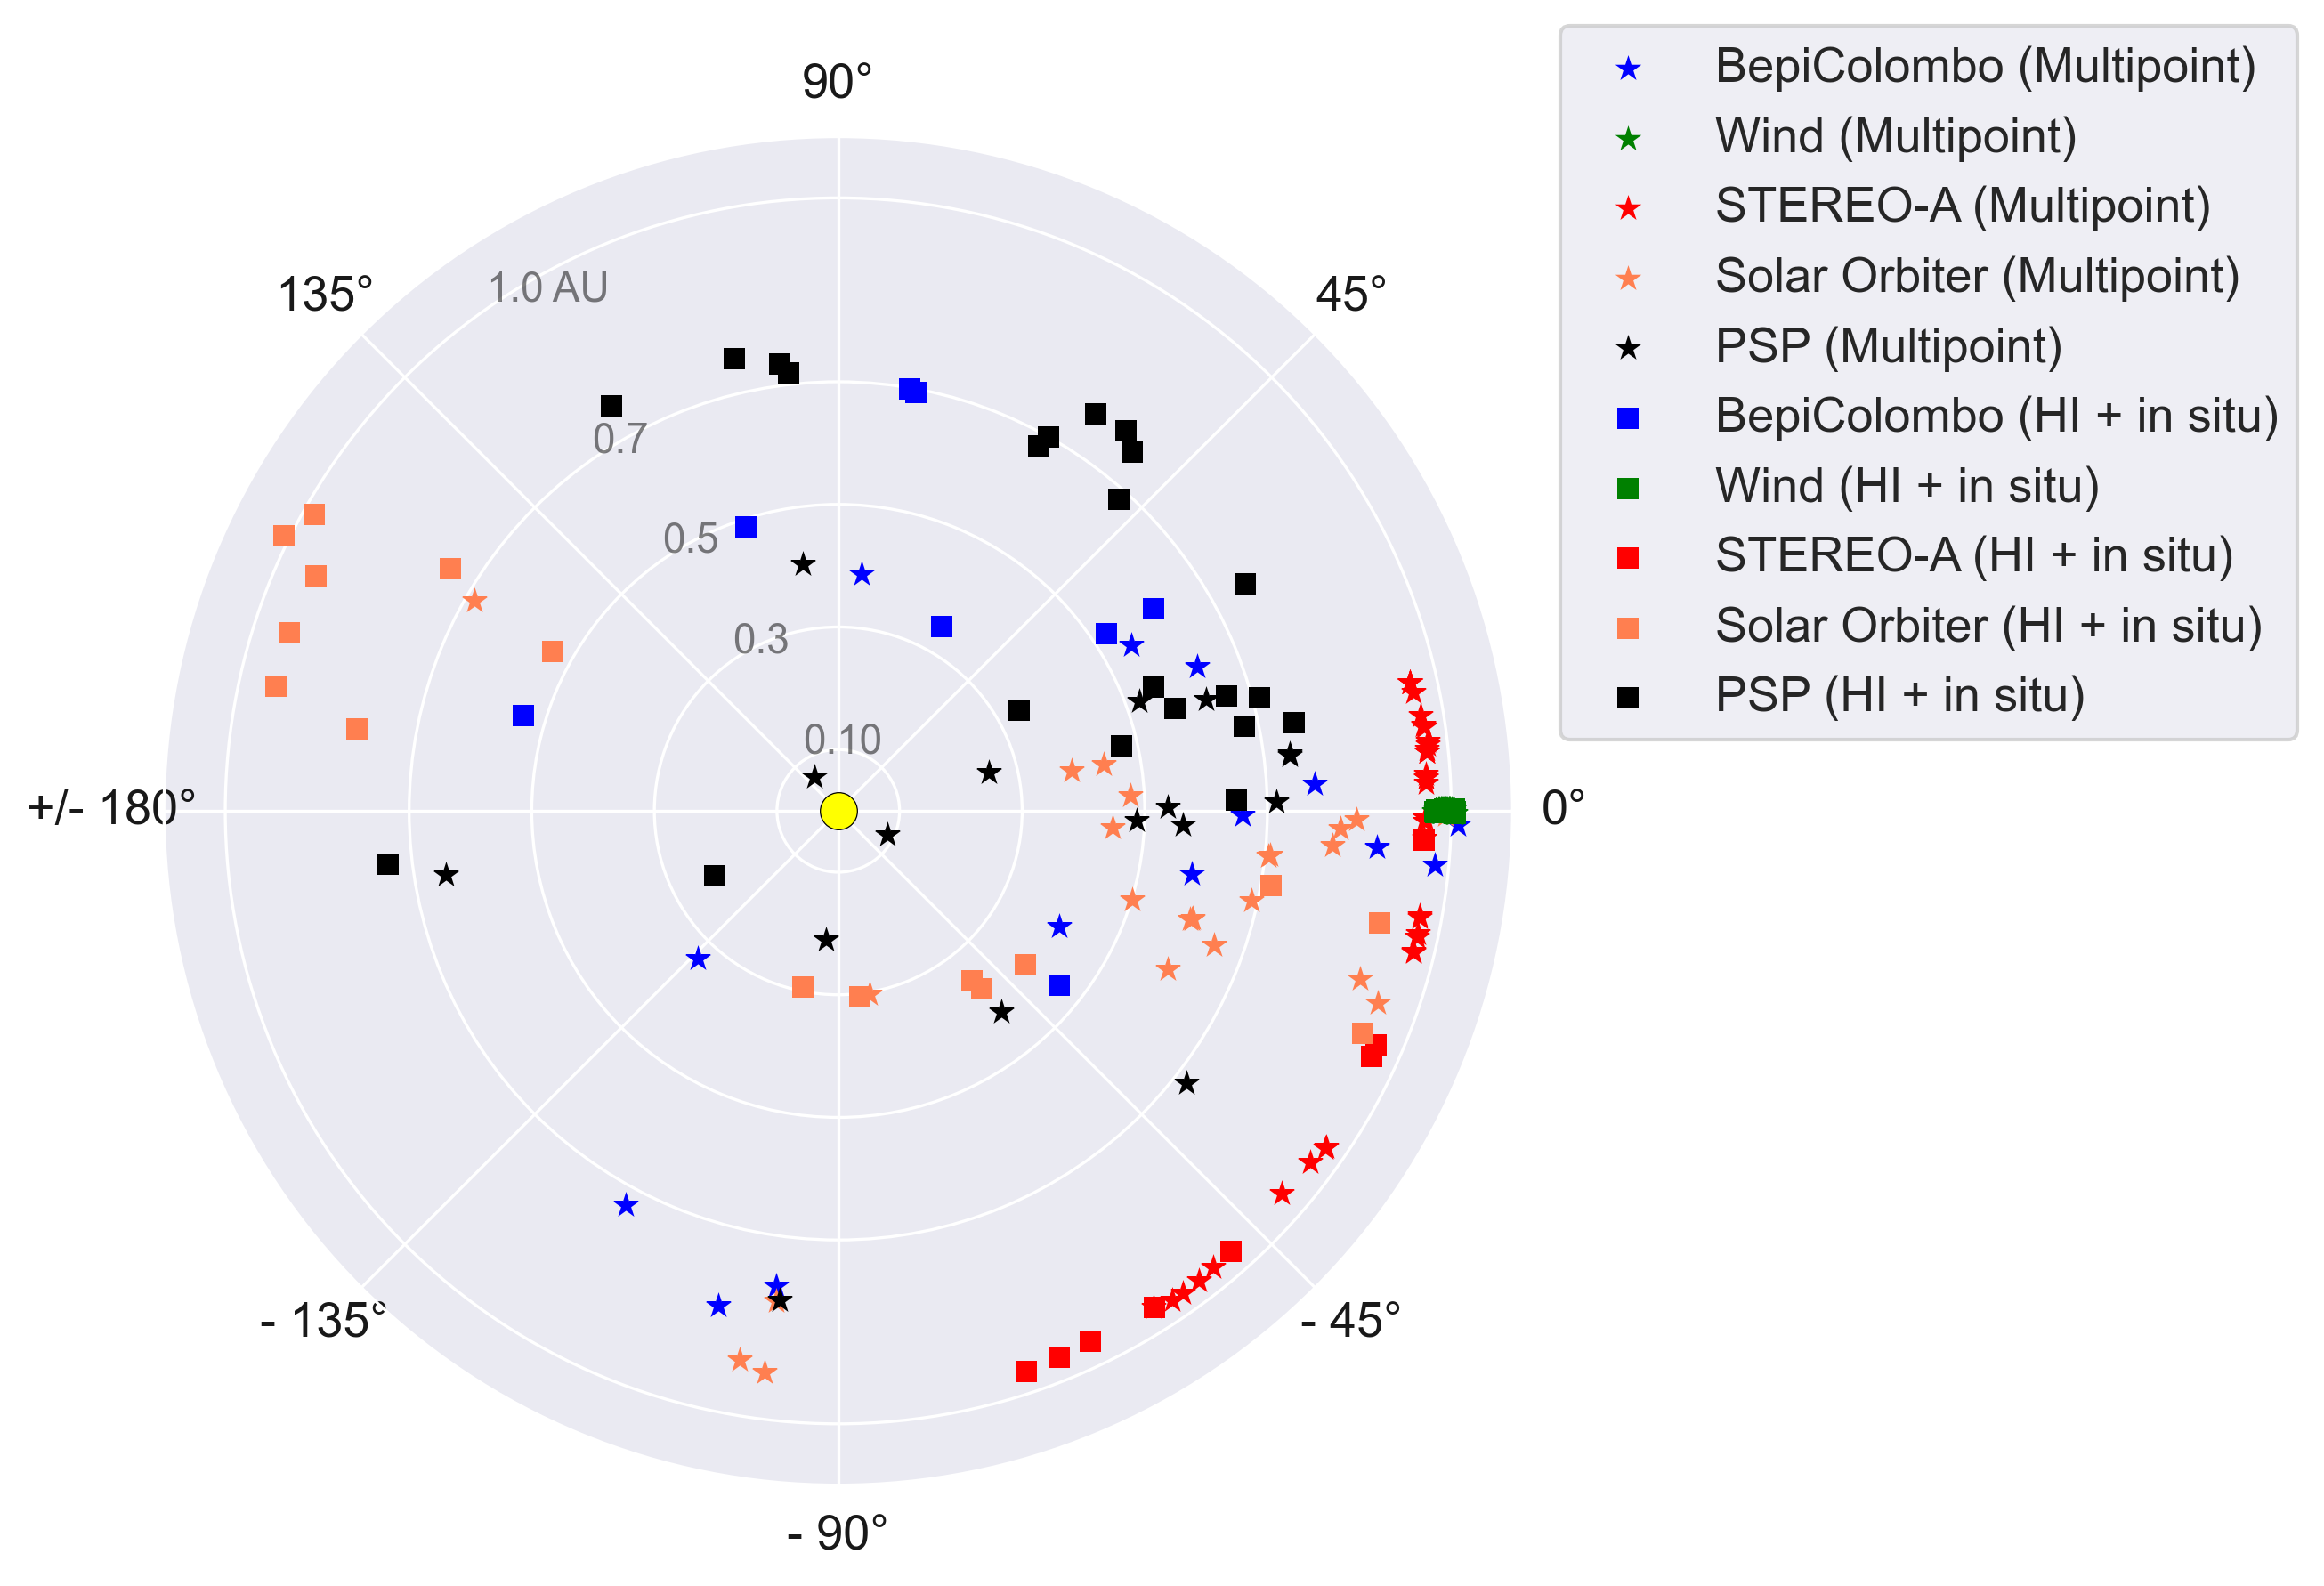

In [28]:
import plotly.express as px

df = df1[lineups.event!=0]
df = df[lineups.event!=3]
df_hi = df[lineups.mp==0]
df_mp = df[lineups.mp!=0]

fsize=13
symsize = 35
symsize1 = 55
fig=plt.figure(2, figsize=(10,6), dpi=300) #full hd
sns.set_style('darkgrid')
ax = fig.add_subplot(projection='polar')

df_bepi = df_mp[df_mp.spacecraft == 'BepiColombo']
df_wind = df_mp[df_mp.spacecraft == 'Wind']
df_sta = df_mp[df_mp.spacecraft == 'STEREO-A']
df_solo = df_mp[df_mp.spacecraft == 'SolarOrbiter']
df_psp = df_mp[df_mp.spacecraft == 'PSP']
ax.scatter(np.deg2rad(df_bepi.sc_heeq_lon), df_bepi.sc_heliodistance, color='blue', s=symsize1, alpha=1,lw=0,zorder=3, marker='*', label='BepiColombo (Multipoint)')
ax.scatter(np.deg2rad(df_wind.sc_heeq_lon), df_wind.sc_heliodistance, color='green', s=symsize1, alpha=1,lw=0,zorder=3, marker='*', label='Wind (Multipoint)')
ax.scatter(np.deg2rad(df_sta.sc_heeq_lon), df_sta.sc_heliodistance, color='red', s=symsize1, alpha=1,lw=0,zorder=3, marker='*', label='STEREO-A (Multipoint)')
ax.scatter(np.deg2rad(df_solo.sc_heeq_lon), df_solo.sc_heliodistance, color='coral', s=symsize1, alpha=1,lw=0,zorder=3, marker='*', label='Solar Orbiter (Multipoint)')
ax.scatter(np.deg2rad(df_psp.sc_heeq_lon), df_psp.sc_heliodistance, color='black', s=symsize1, alpha=1,lw=0,zorder=3, marker='*', label='PSP (Multipoint)')

df_bepi_hi = df_hi[df_hi.spacecraft == 'BepiColombo']
df_wind_hi = df_hi[df_hi.spacecraft == 'Wind']
df_sta_hi = df_hi[df_hi.spacecraft == 'STEREO-A']
df_solo_hi = df_hi[df_hi.spacecraft == 'SolarOrbiter']
df_psp_hi = df_hi[df_hi.spacecraft == 'PSP']
ax.scatter(np.deg2rad(df_bepi_hi.sc_heeq_lon), df_bepi_hi.sc_heliodistance, color='blue', s=symsize, alpha=1,lw=0,zorder=3, marker='s', label='BepiColombo (HI + in situ)')
ax.scatter(np.deg2rad(df_wind_hi.sc_heeq_lon), df_wind_hi.sc_heliodistance, color='green', s=symsize, alpha=1,lw=0,zorder=3, marker='s', label='Wind (HI + in situ)')
ax.scatter(np.deg2rad(df_sta_hi.sc_heeq_lon), df_sta_hi.sc_heliodistance, color='red', s=symsize, alpha=1,lw=0,zorder=3, marker='s', label='STEREO-A (HI + in situ)')
ax.scatter(np.deg2rad(df_solo_hi.sc_heeq_lon), df_solo_hi.sc_heliodistance, color='coral', s=symsize, alpha=1,lw=0,zorder=3, marker='s', label='Solar Orbiter (HI + in situ)')
ax.scatter(np.deg2rad(df_psp_hi.sc_heeq_lon), df_psp_hi.sc_heliodistance, color='black', s=symsize, alpha=1,lw=0,zorder=3, marker='s', label='PSP (HI + in situ)')
    


#for i in range(len(df)):
#    spacecraft = df.spacecraft.iloc[i]
#    color = spacecraft_colors.get(spacecraft) 
backcolor = 'black'
    
#    ax.scatter(np.deg2rad(df.sc_heeq_lon.iloc[i]), df.sc_heliodistance.iloc[i], color=color, s=symsize, alpha=1,lw=0,zorder=3, marker='s', label=color)

plt.thetagrids(range(0,360,45),(u'0\u00b0',u'45\u00b0',u'90\u00b0',u'135\u00b0',u'+/- 180\u00b0',u'- 135\u00b0',u'- 90\u00b0',u'- 45\u00b0'), ha='center', fmt='%d',fontsize=fsize,color=backcolor, alpha=0.9, zorder=4)


plt.rgrids((0.1,0.3,0.5,0.7,1.0),('0.10','0.3','0.5','0.7','1.0 AU'),angle=125, fontsize=fsize-2,alpha=0.5, color=backcolor)
ax.set_ylim(0, 1.1)
ax.scatter(0,0,s=100,c='yellow',alpha=1, edgecolors='black', linewidth=0.3)


#ax.legend(labels=legend_labels, loc='upper right', bbox_to_anchor=(1.15, 1), title='Spacecraft', prop={'size': 10}, markerscale=1.5)
#plt.legend(loc='upper right', fontsize=125, bbox_to_anchor=(1.5, 1.1), prop={'size': 10}, markerscale=1)
plt.legend(loc='upper right', fontsize=13, bbox_to_anchor=(1.6, 1.1))
plt.tight_layout()
plt.savefig('plots/HELIO4CAST_LineupCAT_v3.0.png')